In [1]:
freegroup_dimension = 4
notebook_name = 'train-Copy1.ipynb'

%env CUDA_VISIBLE_DEVICES=1
%env TOKENIZERS_PARALLELISM=false
%env WANDB_PROJECT=homotopy-groups

SEED = 42

from transformers import set_seed

set_seed(SEED)

from IPython.display import clear_output
clear_output()

# DATASET

In [2]:
from dataclasses import dataclass
from os import environ
from typing import Callable

@dataclass
class TrainDatasetConfig:
    freegroup_dimension: int = freegroup_dimension
    max_zero_closure_depth: int = 10
    max_non_zero_closure_depth: int = 30
    max_freegroup_commutees: int = 1
    max_freegroup_commutee_length: int = 10
    max_total_length: int = 400
    min_total_length: int = 0

train_dataset_config = TrainDatasetConfig()

from freegroup.sampling import normal_closure, freegroup, random_tree
from freegroup.tools import flatten, normalize, is_from_singleton_normal_closure, wu_closure, to_string
from random import sample, randint, shuffle, choice
from iteration_utilities import unique_everseen, repeatfunc
from itertools import islice
from utils import compute_multi_label

def train_dataset_fn(config: TrainDatasetConfig):
    
    max_depths = [config.max_zero_closure_depth] +\
        [config.max_non_zero_closure_depth for _ in range(1, config.freegroup_dimension + 1)]
    
    def initial():
        exclude_idx = randint(0, freegroup_dimension)
        words, multi_label = [], []
        
        for idx in range(freegroup_dimension + 1):
            if idx != exclude_idx:
                words.append(normal_closure(
                    method = 'brackets',
                    closure = wu_closure(config.freegroup_dimension, idx),
                    freegroup_dimension = config.freegroup_dimension,
                    depth_method = 'uniform',
                    depth_parameters = {'radius': max_depths[idx]},
                ))
                
        for _ in range(randint(0, config.max_freegroup_commutees)):
            words.append(freegroup(
                freegroup_dimension = freegroup_dimension,
                length_method = 'uniform', 
                length_parameters = {'radius': config.max_freegroup_commutee_length},
            ))

        shuffle(words)
        return {
            'word': normalize(flatten(random_tree(words))),
        }
    
    def add_multi_label(entry):
        entry['multi_label'] = compute_multi_label(entry['word'], freegroup_dimension = config.freegroup_dimension)
        return entry
        
    def condition(entry):
        word, multi_label = entry['word'], entry['multi_label']
        
        if config.min_total_length >= len(word) or len(word) >= config.max_total_length:
            return False
        
        if sum(multi_label) != config.freegroup_dimension:
            return False
        return True        
    
    return unique_everseen(filter(condition, map(add_multi_label, repeatfunc(initial))), key=lambda x: to_string(x['word']))

To sample one item: 0.006331821069121361


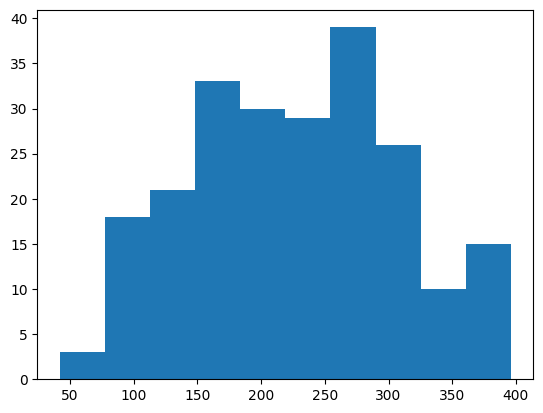

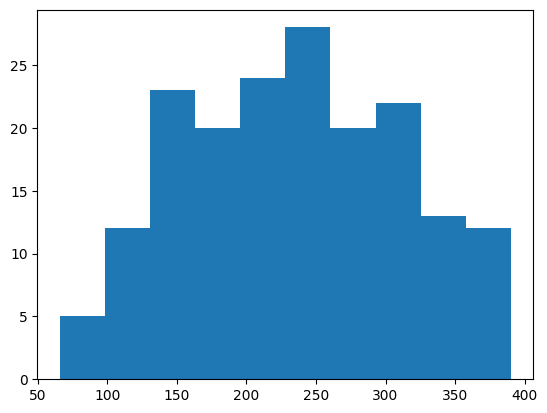

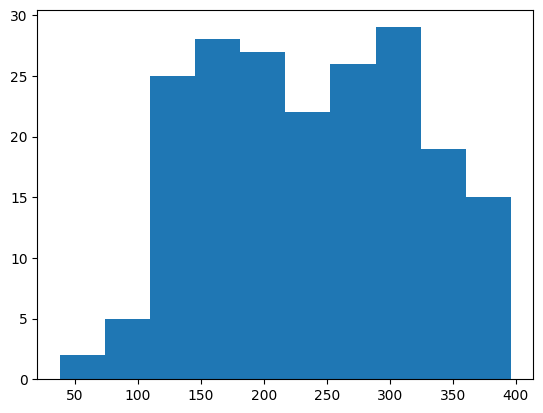

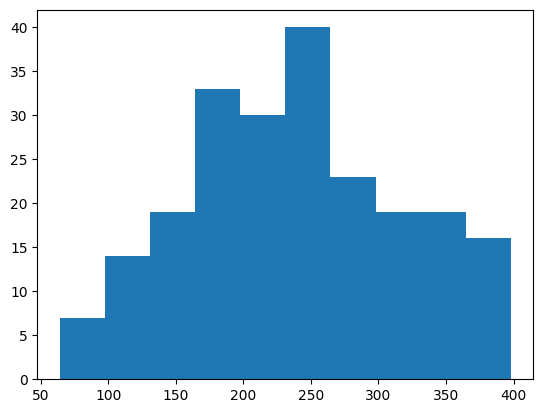

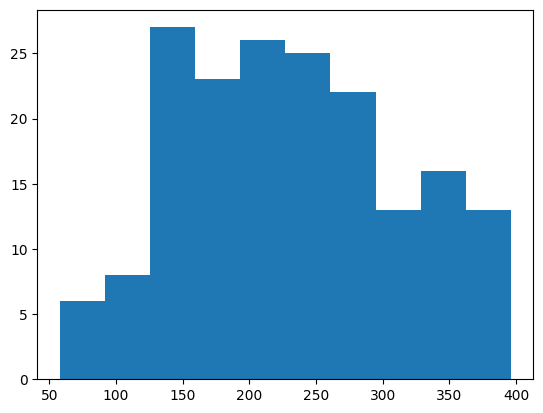

0 1 224 179 KstestResult(statistic=0.07220171588188348, pvalue=0.6412961736955581)
0 2 224 198 KstestResult(statistic=0.09050324675324675, pvalue=0.32905293845460304)
0 3 224 220 KstestResult(statistic=0.08149350649350649, pvalue=0.42087345422898986)
0 4 224 179 KstestResult(statistic=0.06943335993615324, pvalue=0.6900961523255476)
1 2 179 198 KstestResult(statistic=0.07175102985158852, pvalue=0.6812461654360905)
1 3 179 220 KstestResult(statistic=0.04878110716099543, pvalue=0.960376136644764)
1 4 179 179 KstestResult(statistic=0.055865921787709494, pvalue=0.9437310754539261)
2 3 198 220 KstestResult(statistic=0.0691919191919192, pvalue=0.6694393011668364)
2 4 198 179 KstestResult(statistic=0.09325094520625248, pvalue=0.35715058053267135)
3 4 220 179 KstestResult(statistic=0.06503301168105638, pvalue=0.765108474101323)


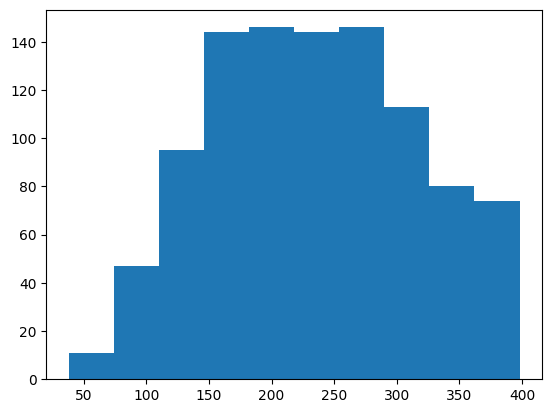

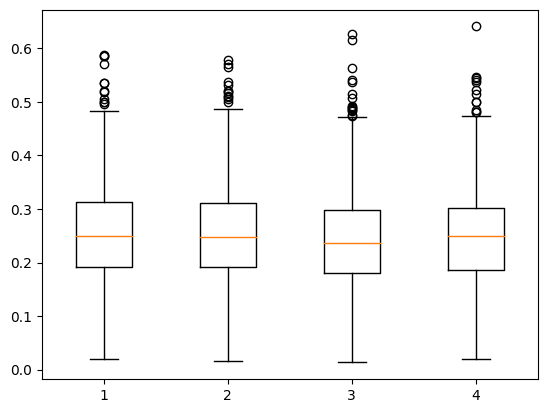

In [3]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import islice
from scipy.stats import ks_2samp
from utils import sample_dataset

visualize, time = sample_dataset(train_dataset_fn, size = 1000, return_time = True, config = train_dataset_config)

print(f'To sample one item: {time / 1000}')

words = list(map(lambda x: x['word'], visualize))
masks = list(map(lambda x: x['multi_label'], visualize))

a = []
for mask in [0b11110, 0b11101, 0b11011, 0b10111, 0b01111]:
    a.append(list(filter(lambda x: sum(map(lambda p: 2 ** p[0] * p[1], enumerate(x['multi_label']))) == mask, visualize)))
    plt.hist(list(map(lambda x: len(x['word']), a[-1])))
    plt.show()
        

for idx, b in enumerate(a):
    for jdx, c in enumerate(a):
        if jdx <= idx: continue
        res = ks_2samp(list(map(lambda x: len(x['word']), b)), list(map(lambda x: len(x['word']), c)))
        print(idx, jdx, len(b), len(c), res)
        
plt.hist(list(map(len, words)))
plt.show()

ratios = [] 
for g in range(1, freegroup_dimension + 1):
    occurences = map(lambda x: len([y for y in x if abs(y) == g]), words)
    lens = map(lambda x: len(x), words)
    ratios.append(list(map(lambda p: p[0] / p[1], zip(occurences, lens))))
plt.boxplot(ratios)
plt.show()
    


In [4]:
from dataclasses import dataclass
from os import environ
from typing import Callable

@dataclass
class TrivialDatasetConfig:
    freegroup_dimension: int = freegroup_dimension
    max_zero_closure_depth: int = 8
    max_non_zero_closure_depth: int = 15
    max_freegroup_commutees: int = 1
    max_freegroup_commutee_length: int = 5
    max_symmetric_commutators: int = 1
    max_total_length: int = 400
    min_total_length: int = 0

trivial_dataset_config = TrivialDatasetConfig()

from freegroup.sampling import normal_closure, freegroup, random_tree
from freegroup.tools import from_string, flatten, normalize, is_from_singleton_normal_closure, wu_closure, Mult
from random import sample, randint, shuffle
from iteration_utilities import unique_everseen, repeatfunc
from itertools import islice
from utils import compute_multi_label
from tqdm import tqdm

def trivial_dataset_fn(config: TrivialDatasetConfig):
    
    max_depths = [config.max_zero_closure_depth] +\
        [config.max_non_zero_closure_depth for _ in range(1, config.freegroup_dimension + 1)]
    
    def initial():
        
        def symmetric_commutator():
            words, multi_label = [], []
        
            for idx in range(freegroup_dimension + 1):
                words.append(normal_closure(
                    method = 'brackets',
                    closure = wu_closure(config.freegroup_dimension, idx),
                    freegroup_dimension = config.freegroup_dimension,
                    depth_method = 'uniform',
                    depth_parameters = {'radius': max_depths[idx]},
                ))
                
            for _ in range(randint(0, config.max_freegroup_commutees)):
                words.append(freegroup(
                    freegroup_dimension = freegroup_dimension,
                    length_method = 'uniform', 
                    length_parameters = {'radius': config.max_freegroup_commutee_length},
                ))
                
            shuffle(words)
            return normalize(random_tree(words))
        
        words = [symmetric_commutator() for _ in range(randint(1, config.max_symmetric_commutators))]
        return {
            'word': normalize(flatten(Mult(words))),
        }
    
    def add_multi_label(entry):
        entry['multi_label'] = compute_multi_label(entry['word'], freegroup_dimension = config.freegroup_dimension)
        return entry
    
    def condition(entry):
        word = entry['word']
        
        if config.min_total_length >= len(word) or len(word) >= config.max_total_length:
            return False
        
        if sum(entry['multi_label']) != freegroup_dimension + 1:
            return False
        
        return True
    
    result = filter(condition, map(add_multi_label, repeatfunc(initial)))
    return unique_everseen(result, key=lambda e: to_string(e['word']))

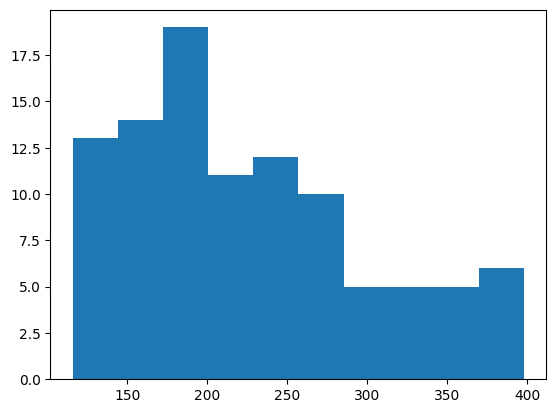

In [5]:
from matplotlib import pyplot as plt
from utils import sample_dataset

visualize = sample_dataset(trivial_dataset_fn, size = 100, config = trivial_dataset_config)

words = list(map(lambda x: x['word'], visualize))
masks = list(map(lambda x: x['multi_label'], visualize))
    
plt.hist(list(map(lambda x: len(x), words)))
plt.show()


In [6]:
from freegroup.tools import (
    from_string, flatten, normalize, is_from_singleton_normal_closure, wu_closure
)
from utils import compute_multi_label

if freegroup_dimension == 3:
    non_trivial = normalize(flatten(from_string('[[x, y], [x, yz]]', method = 'lu')))
elif freegroup_dimension == 4:
    non_trivial = normalize(flatten(from_string('[[[x, y], [x, yz]], [[x, y], [x, yzp]]]', method='lu')))
else: raise ValueError(f'There is no non trivial dataset for freegroup dimension = {freegroup_dimension}')

non_trivial_dataset = []
permutation = list(range(freegroup_dimension))
for t in range(freegroup_dimension):
    non_trivial_dataset.append([(-1 if f < 0 else 1) * ((permutation[t:] + permutation[:t])[abs(f) - 1] + 1) for f in non_trivial])
    for idx in range(freegroup_dimension + 1):
        if not is_from_singleton_normal_closure(non_trivial_dataset[-1], wu_closure(freegroup_dimension, idx)):
            raise ValueError('Not from intersection')
            

non_trivial_dataset = [dict(word = x, multi_label = compute_multi_label(x, freegroup_dimension)) for x in non_trivial_dataset]

# TRAIN

In [7]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast.from_pretrained(f'/home/kibrq/draft/tokenizer/word-level-tokenizer-{freegroup_dimension}')

tokenizer.add_special_tokens({'additional_special_tokens': ['y', 'n', ':']})
def prompt(multi_label):
    return ' '.join('y' if f else 'n' for f in multi_label) + ' : '

In [8]:
from transformers import GPT2Config, AutoModelForCausalLM

model_config = GPT2Config(
    vocab_size = len(tokenizer),
    n_embd     = 768,
    n_layer    = 16,
    n_head     = 12,
    n_inner    = 512,
    
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id,
    pad_token_id = tokenizer.pad_token_id,
)

model = AutoModelForCausalLM.from_config(model_config)


In [9]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

51251456

In [10]:
from freegroup.tools import to_string
from os import environ

def train_preprocess(entry):
    input_ids = tokenizer(prompt(entry['multi_label']) + to_string(entry['word'], method = 'integer')).input_ids
    labels = input_ids[::]

    return {'input_ids': input_ids, 'labels': labels}

def gen_preprocess(entry):
    input_ids = tokenizer(prompt([1] * (freegroup_dimension + 1)) + to_string(entry, method = 'integer')).input_ids
    return {'input_ids': input_ids}

from typing import List, Dict, Any
from torch import tensor, ones_like
from random import randint

def train_data_collator(batch: List[Dict[str, Any]]):
    def max_length_pad(batch: List, pad_token_id):
        max_length = max(map(len, batch))
        batch = map(lambda x: x + [pad_token_id] * (max_length - len(x)), batch)
        batch = tensor(list(batch), dtype=int)
        return batch
    
    input_ids = list(map(lambda x: x['input_ids'], batch))
    labels = list(map(lambda x: x['labels'], batch))
    
    labels    = max_length_pad(labels[::], -100)
    labels[:, :1 + freegroup_dimension + 1 + 1] = -100
    
    input_ids = max_length_pad(input_ids, tokenizer.pad_token_id)
        
    attention_mask = ones_like(input_ids)
    attention_mask.masked_fill_(input_ids == tokenizer.pad_token_id, -100)

    return {
        'input_ids': input_ids,
        'labels': labels,
        'attention_mask': attention_mask,
    }

def gen_data_collator(batch: List[Dict[str, Any]]):
    def max_length_pad(batch: List, pad_token_id):
        max_length = max(map(len, batch))
        batch = map(lambda x: x + [pad_token_id] * (max_length - len(x)), batch)
        batch = tensor(list(batch), dtype=int)
        return batch
    
    input_ids = list(map(lambda x: x['input_ids'], batch))
    input_ids = max_length_pad(input_ids, 0)
    
    return {'inputs': input_ids[:, :-1]}

In [11]:
from tqdm import tqdm
from itertools import islice
from freegroup.sampling import freegroup_generator
from utils import sample_dataset

eval_dataset_size = 64 * 20
eval_dataset = {
    'validation': sample_dataset(train_dataset_fn, size = eval_dataset_size, preprocess = train_preprocess, config = train_dataset_config),
    'trivial': sample_dataset(trivial_dataset_fn, size = eval_dataset_size, preprocess = train_preprocess, config = trivial_dataset_config),
    'non_trivial': list(map(train_preprocess, non_trivial_dataset)),
}

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

In [ ]:
from datetime import datetime
from typing import List, Dict

from transformers import TrainingArguments, Trainer
import wandb
from traceback import format_exc

from dataclasses import dataclass, asdict, field
from numpy import mean

from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from torch import save, load

from os import makedirs
from os.path import exists
from shutil import rmtree

from torch.utils.data import DataLoader
from utils import RefillableDataset, refillable_dataset
from utils import NoLastTokenReductionProcessor, SuppressTokensLogitsProcessor
from utils import completion_ratio, reduction_ratio
from transformers import LogitsProcessorList, TopPLogitsWarper, RepetitionPenaltyLogitsProcessor
from torch import no_grad

from freegroup.tools import batch_from_string

config = {
    'freegroup_dimension': freegroup_dimension,
    'tags': ['LM', 'gpt2-large', 'prompt'],
    'train': {
        'batch_size': 16,
        
        'steps': int(5e5),
        'log_steps': 400,
        'save_steps': 25000,
        
        'optimizer': {
            'name': 'AdamW',
            'learning_rate': 3e-6,
        },
        
        'scheduler': {
            'name': 'Linear',
            'steps': 200,
        },
        
        'dataset': {
            'fn': train_dataset_fn,
            'preprocess': train_preprocess,
            'config': train_dataset_config,
            'size': 64 * 100,
            'max_calls': 3,
        },
    },
    'eval': {
        'steps': 200,
        'batch_size': 16,
    },
    'gen': {
        'steps': 2500,
        'batch_size': 16,
        'dataset': {
            'prefix_5': {
                'size': 64 * 5,
                'params': {
                    'length_method': 'c',
                    'length_parameters': {'radius': 5}
                }
            },
            'prefix_7': {
                'size': 64 * 5,
                'params': {
                    'length_method': 'c',
                    'length_parameters': {'radius': 7}
                }
            },
            'prefix_10': {
                'size': 64 * 5,
                'params': {
                    'length_method': 'c',
                    'length_parameters': {'radius': 10}
                }
            },
        },
        
        'methods': {
            'beam': {
                'num_beams': 5,
                'num_return_sequences': 5,
                'max_length': 400,
                'logits_processor': LogitsProcessorList([
                    NoLastTokenReductionProcessor.from_tokenizer(freegroup_dimension, tokenizer),
                    SuppressTokensLogitsProcessor(tokenizer.convert_tokens_to_ids(['[', ']', ',', 'y', 'n', ':'])),
                    RepetitionPenaltyLogitsProcessor(1.2),
                ]),
            },

            'sample': {
                'do_sample': True,
                'num_return_sequences': 5,
                'max_length': 400,
                'logits_processor': LogitsProcessorList([
                    NoLastTokenReductionProcessor.from_tokenizer(freegroup_dimension, tokenizer),
                    SuppressTokensLogitsProcessor(tokenizer.convert_tokens_to_ids(['[', ']', ',', 'y', 'n', ':'])),
                    TopPLogitsWarper(0.9),
                ]),
            },
        },
    },
}

with    wandb.init(job_type = 'train', notes = '', tags = config['tags'], config = config) as run,\
        refillable_dataset(
            config['train']['dataset']['fn'],
            config['train']['dataset']['preprocess'],
            config['train']['dataset']['config'],
            config['train']['dataset']['size'],
            config['train']['dataset']['max_calls']
         ) as train_dataset,\
         tqdm(total = config['train']['steps']) as progress:
    
    model.to('cuda')
    
    metrics = {}
    def add_metric(name, value):
        if not name in metrics:
            metrics[name] = []
        metrics[name].append(value)
    def finalize_metric(name):
        run.log({name: mean(metrics[name])}, commit=False, step = progress.n)
        metrics[name] = []
    def finalize_metrics():
        run.log({}, commit = True, step = progress.n)
    
    artifact = wandb.Artifact(f'notebook', type='notebook')
    artifact.add_file(notebook_name)
    run.log_artifact(artifact)
    
    if config['train']['optimizer']['name'] == 'AdamW':
        optimizer = AdamW(params = model.parameters(), lr = config['train']['optimizer']['learning_rate'])
        
    if config['train']['scheduler']['name'] == 'Linear':
        scheduler = LinearLR(
            optimizer,
            start_factor=1., end_factor=.5,
            total_iters=config['train']['steps'] // config['train']['scheduler']['steps']
        )
    
    dataloader = DataLoader(
        train_dataset,
        batch_size = config['train']['batch_size'],
        collate_fn = train_data_collator
    ).__iter__()
    
    while progress.n < config['train']['steps']:
        progress.update()
        model.train()
        
        try:
            batch = next(dataloader)
        except StopIteration:
            dataloader = DataLoader(
                train_dataset,
                batch_size = config['train']['batch_size'],
                collate_fn = train_data_collator
            ).__iter__()
            continue
            
        for k, v in batch.items():
            batch[k] = v.to(model.device)
            
        outputs = model(**batch)
        optimizer.zero_grad()
        outputs[0].backward()
        optimizer.step()
        
        add_metric('train/loss', outputs[0].item())
        
        if progress.n % config['train']['scheduler']['steps'] == 0:
            scheduler.step()
            
        if progress.n % config['eval']['steps'] == 0:
            model.eval()
            for key, dataset in eval_dataset.items():
                for batch in DataLoader(
                    dataset, shuffle=True,
                    batch_size = config['eval']['batch_size'],
                    collate_fn = train_data_collator
                ):
                    for k, v in batch.items():
                        batch[k] = v.to(model.device)
                    with no_grad():
                        outputs = model(**batch)
                    add_metric(f'eval/{key}_loss', outputs[0].item())
                finalize_metric(f'eval/{key}_loss')
                
        if progress.n % config['gen']['steps'] == 0:
            model.eval()
            
            gen_metric_names = ['completion_ratio'] + ['reduction_ratio'] +\
                [f'reduction_ratio_{idx}' for idx in range(freegroup_dimension + 1)]
            
            gen_dataset = {
                key: sample_dataset(freegroup_generator, size = conf['size'], preprocess = gen_preprocess,
                                    freegroup_dimension = freegroup_dimension, **conf['params'])
                for key, conf in config['gen']['dataset'].items()
            }
            
            for dataset_key, dataset in gen_dataset.items():
                for method_key, method in config['gen']['methods'].items():                        
                    for batch in DataLoader(
                        dataset, shuffle = True,
                        batch_size = config['gen']['batch_size'],
                        collate_fn=gen_data_collator
                    ):
                        for k, v in batch.items():
                            batch[k] = v.to(model.device)
                            
                        outputs = model.generate(**batch, **method)
                        outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
                        outputs = batch_from_string(outputs)
                        
                        _metrics = {}
                        _metrics.update(completion_ratio(outputs, batch['inputs'], freegroup_dimension = config['freegroup_dimension']))
                        _metrics.update(reduction_ratio(outputs, batch['inputs'], freegroup_dimension = config['freegroup_dimension']))
                        
                        for k, v in _metrics.items():
                            add_metric(f'gen/{method_key}_{dataset_key}/{k}', v)
                            
                    for name in gen_metric_names:
                        finalize_metric(f'gen/{method_key}_{dataset_key}/{name}')
        
        if progress.n % config['train']['save_steps'] == 0:
            model_artifact = wandb.Artifact(run.id, type='model')
            checkpoint = f'{run.dir}/checkpoint'
            if exists(checkpoint): rmtree(checkpoint)
            makedirs(checkpoint)
            model.save_pretrained(checkpoint)
            tokenizer.save_pretrained(checkpoint)
            save(optimizer, f'{checkpoint}/optimizer.pt')
            save(scheduler, f'{checkpoint}/scheduler.pt')
            model_artifact.add_dir(checkpoint)
            run.log_artifact(model_artifact)
            
        if progress.n % config['train']['log_steps'] == 0:
            finalize_metric('train/loss')
            
        finalize_metrics()